In [19]:
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVR
from qiime2 import Artifact
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Run KernelPCA and SVR with linear vs. RBF kernels

In [55]:
# Collect R2 values
r2 = pd.DataFrame(columns=['approach','fraction','axis','measure','R2','%explained'])

# Biom tables
tables = {
    'swab': 'input_qza/dada_table.no_ntc.min2.qza',
    'skin': 'denoised_tables/skin_microbiome.qza'
}

# Faith PD values
faith_pds = {
    'swab': 'diversity-swab/faith_pd_vector.qza',
    'skin': 'diversity-skin/faith_pd_vector.qza'
}

# linear or RBF SVR
def reg(d,x,y,approach):
    Y = d[y].tolist()
    X = [[i] for i in d[x].tolist()]
    if approach == 'linear':
        clf = SVR(kernel='linear')
        clf.fit(X, Y)
        return abs(clf.score(X, Y))
    # else RBF (default)
    clf = SVR(gamma='scale')
    clf.fit(X, Y)
    return abs(clf.score(X, Y))

# Add the PCA axis or Faith PD vector to the metadata table
def get_axis(index):
    if axis == 'faith_pd':
        try:
            return faith_pd.at[index,'faith_pd']
        except:
            return np.nan
    else:   
        try:
            return ordination.at[index,axis]
        except:
            return np.nan

# Render nice symbols
symbol = {
    'T':u'T \N{DEGREE SIGN}C',
    'Conductivity  ':u'Conductivity \N{Greek Small Letter Mu}S',
    'pH':'pH',
    'PercentO':u'%O\u00b2'
}
        
for approach in ['linear','rbf']:
    for fraction in ['skin', 'swab']:
        for axis in [1,2,'faith_pd']:
            
            # read metadata
            regression = pd.read_csv('fish_samples_metadata_loc_code_correct_sp.tsv',index_col=0, sep='\t')
            
            # read the biom table and convert to unweighted
            unweighted = Artifact.load(tables[fraction]).view(pd.DataFrame)
            for ind, row in unweighted.iterrows():
                for col in unweighted:
                    if row[col] > 0:
                        unweighted.at[ind,col]=1
                        
            # produce ordination
            transformer = KernelPCA(n_components=30,kernel=approach)
            X_transformed = transformer.fit_transform(unweighted.to_numpy())
            ordination = pd.DataFrame(data=X_transformed,index=unweighted.index, columns=list(range(1,31)))
            explained_variance = np.var(X_transformed, axis=0)
            explained_variance_ratio = explained_variance / np.sum(explained_variance)
            
            # read faith pd
            
            qza = faith_pds[fraction]
            a = !unzip $qza
            digest = a[1].split('/')[0].replace('  inflating: ','')
            inf = digest + '/data/alpha-diversity.tsv'
            faith_pd = pd.read_csv(inf,index_col=0,sep='\t')
            !rm -r $digest
            
            # add the faith_pd or PCA axis to the metadata table
            regression[axis] = regression.index.map(get_axis)
            
            regression = regression.loc[
                (regression['type'].isin(['Swab']) & (regression.Stream!='N'))
            ]
            
            regression['pH'] = regression.pH.astype(float)
            regression['PercentO'] = regression.PercentO.astype(float)
            
            # run regression
            for measure in ['T', 'Conductivity  ','pH','PercentO']:
                d = regression.loc[regression['type'] == 'Swab',[measure,axis]].dropna().sort_values(measure)
                explained = None
                if axis != 'faith_pd':
                    explained = explained_variance_ratio[axis-1]
                r2.loc[len(r2)] = [approach,fraction,axis,symbol[measure],reg(d,measure,axis,approach),explained]
                
!mkdir -p linear_vs_nonlinear_R2
r2.to_csv('linear_vs_nonlinear_R2/r2.tsv',sep='\t',index=False)

### Make figure

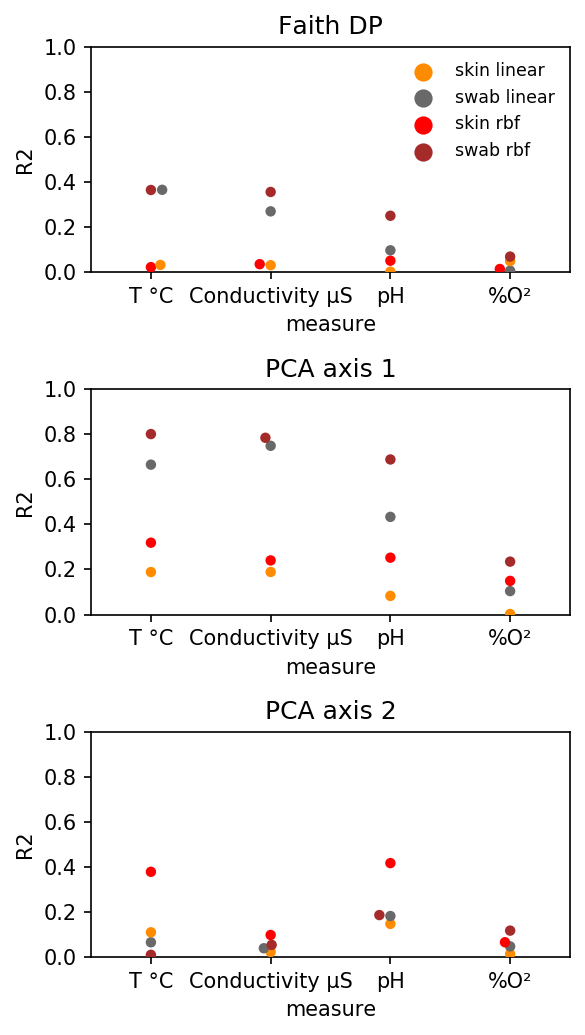

In [56]:
fig, axes = plt.subplots(nrows=3,figsize=(4,7),dpi=150, tight_layout=True)

def add_group(series):
    return series['fraction'] + ' ' +series['approach']

r2['analysis'] = r2.apply(add_group,axis=1)

order = ['skin linear', 'swab linear', 'skin rbf', 'swab rbf']
colors = ['darkorange','dimgray','red','brown']

ax = axes[0]
sns.swarmplot(x='measure',y='R2', data=r2.loc[r2.axis=='faith_pd'], hue='analysis',ax=ax, palette=colors, hue_order=order)
ax.set_title('Faith DP')
ax.legend(frameon=False,markerscale=1,fontsize='small')
ax.set_ylim(0,1)

ax = axes[1]

sns.swarmplot(x='measure',y='R2', data=r2.loc[r2.axis==1], hue='analysis', ax=ax, palette=colors, hue_order=order)
ax.set_title('PCA axis 1')
ax.legend().set_visible(False)
ax.set_ylim(0,1)

ax = axes[2]

sns.swarmplot(x='measure',y='R2', data=r2.loc[r2.axis==2], hue='analysis', ax=ax, palette=colors, hue_order=order)
ax.set_title('PCA axis 2')
ax.legend().set_visible(False)
ax.set_ylim(0,1)

plt.savefig('linear_vs_nonlinear_R2/FileS1_fig.png')